In [1]:
!wget https://zenodo.org/record/3902685/files/BIDMC32RR_TRAIN.ts

--2023-08-28 18:31:23--  https://zenodo.org/record/3902685/files/BIDMC32RR_TRAIN.ts
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 468337002 (447M) [application/octet-stream]
Saving to: ‘BIDMC32RR_TRAIN.ts’

BIDMC32RR_TRAIN.ts  100%[===================>] 446.64M   885KB/s    in 2m 25s  

2023-08-28 18:33:49 (3.09 MB/s) - ‘BIDMC32RR_TRAIN.ts’ saved [468337002/468337002]



Vamos olhar para o dataset primeiro - seguindo a leitura recomendada pelo repositório (TSERegression) - e plotar apenas um trecho

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('BIDMC32RR_TRAIN.ts', delimiter='\t', encoding="ISO-8859-1")
lis = data['# Dataset Information'][20].split(',')

ppg =  [float(i) for i in lis[:3999]]
ppg += [float(lis[3999].split(':')[0])]

ecg =  [float(lis[3999].split(':')[1])]
ecg += [float(i) for i in lis[4000:-1]]
ecg += [float(lis[-1].split(':')[0])]

<Axes: >

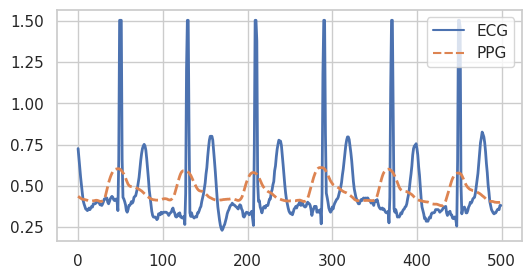

In [ ]:
dicio = {'ECG': ecg, 'PPG': ppg}
data = pd.DataFrame(dicio)

sns.set_theme(style="whitegrid")
plt.figure(figsize=[6,3])
sns.lineplot(data=data[:500], linewidth=2)

Primeiro, para o ECG. Precisamos determinar umas coisas: sampling rate (sei pelo dataset), nobs, tamnho do passo de tempo e de frequência

In [ ]:
from scipy.fft import fft, ifft
import numpy as np

ecg_data = ecg[:500]

sr = 125 # sampling rate
N = len(ecg_data)

time_step = 1 / sr
freq_step = sr / N

t = np.linspace(0, (N-1)*time_step, N)
f = np.linspace(0, (N-1)*freq_step, N)[1:int(N/2)+1]

y = fft(ecg_data)
y_mag = np.abs(y) / N
y_mag = 2*y_mag[1:int(N/2)+1]

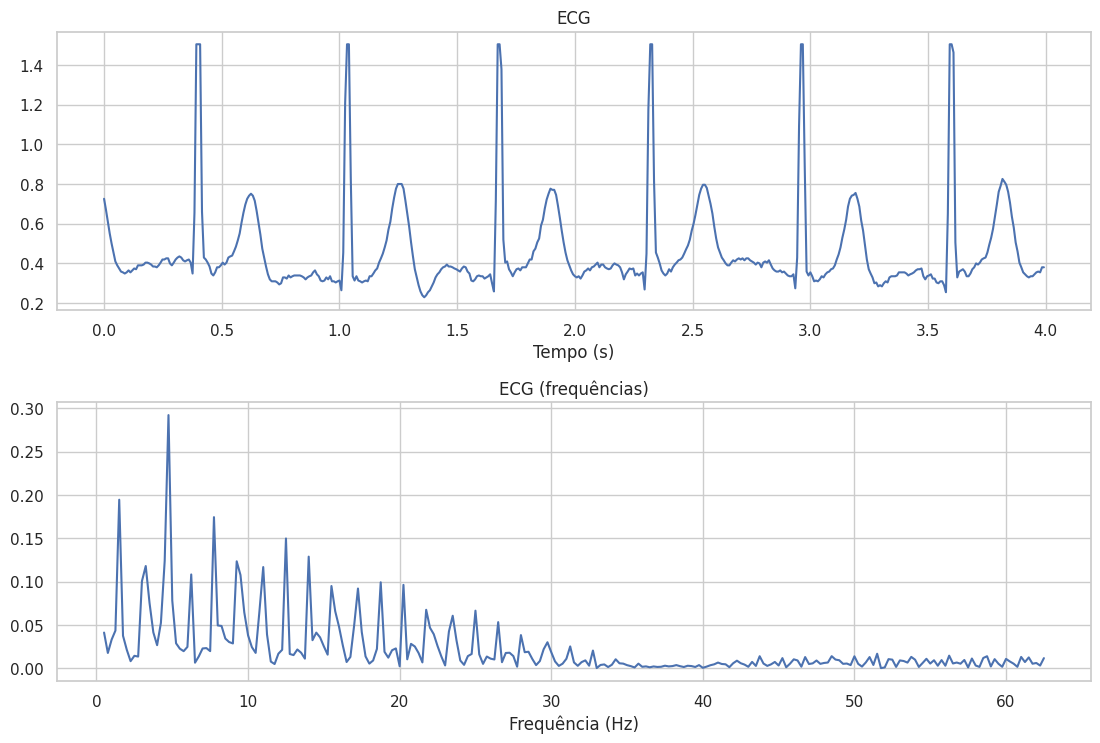

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=[12,8])
fig.tight_layout(pad=3.5)

ax[0].plot(t, ecg_data)
ax[0].set_title('ECG')
ax[0].set_xlabel('Tempo (s)')


ax[1].plot(f[1:int(N/2)+1], 2*y_mag[1:int(N/2)+1])
ax[1].set_title('ECG (frequências)')
ax[1].set_xlabel('Frequência (Hz)')

plt.show()

Agora, PPG

In [ ]:
ppg_data = ppg[:500]

sr = 125 # sampling rate
N = len(ppg_data)

time_step = 1 / sr
freq_step = sr / N

t = np.linspace(0, (N-1)*time_step, N)
f = np.linspace(0, (N-1)*freq_step, N)[1:int(N/2)+1]

y = fft(ppg_data)
y_mag = np.abs(y) / N
y_mag = 2*y_mag[1:int(N/2)+1]

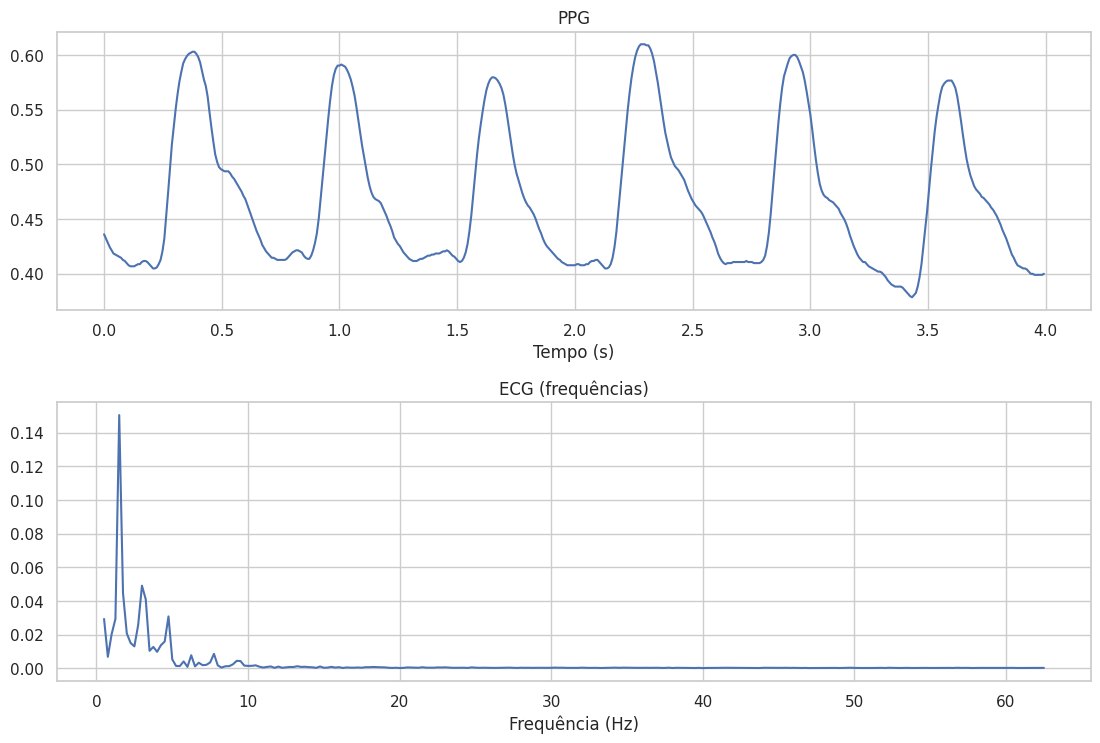

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=[12,8])
fig.tight_layout(pad=3.5)

ax[0].plot(t, ppg_data)
ax[0].set_title('PPG')
ax[0].set_xlabel('Tempo (s)')


ax[1].plot(f[1:int(N/2)+1], 2*y_mag[1:int(N/2)+1])
ax[1].set_title('ECG (frequências)')
ax[1].set_xlabel('Frequência (Hz)')

plt.show()

Adicionar ruído gaussiano e limpar com média móvel

In [ ]:
def fftnoise(f):
    f = np.array(f, dtype='complex')
    Np = (len(f) - 1) // 2
    phases = np.random.rand(Np) * 2 * np.pi
    phases = np.cos(phases) + 1j * np.sin(phases)
    f[1:Np+1] *= phases
    f[-1:-1-Np:-1] = np.conj(f[1:Np+1])
    return np.fft.ifft(f).real

def band_limited_noise(min_freq, max_freq, samples=1024, samplerate=1):
    freqs = np.abs(np.fft.fftfreq(samples, 1/samplerate))
    f = np.zeros(samples)
    idx = np.where(np.logical_and(freqs>=min_freq, freqs<=max_freq))[0]
    f[idx] = 1
    return fftnoise(f)

In [ ]:
noise = band_limited_noise(40, 124/2, 500, 125)
ecg_noisy = ecg_data + noise*2

y = fft(ecg_data)
y_mag = np.abs(y) / N
y_mag = 2*y_mag[1:int(N/2)+1]

y = fft(ecg_noisy)
y_mag2 = np.abs(y) / N
y_mag2 = 2*y_mag2[1:int(N/2)+1]

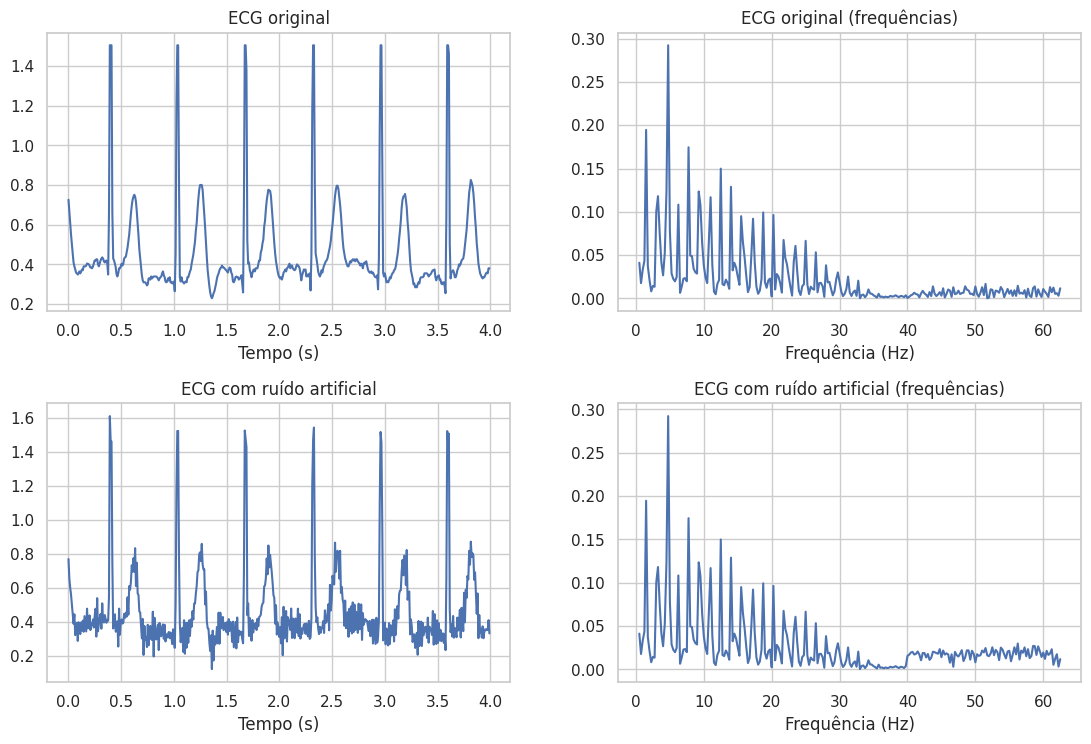

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[12,8])
fig.tight_layout(pad=3.5)

ax[0][0].plot(t, ecg_data)
ax[0][0].set_title('ECG original')
ax[0][0].set_xlabel('Tempo (s)')

ax[1][0].plot(t, ecg_noisy)
ax[1][0].set_title('ECG com ruído artificial')
ax[1][0].set_xlabel('Tempo (s)')


ax[0][1].plot(f[1:int(N/2)+1], 2*y_mag[1:int(N/2)+1])
ax[0][1].set_title('ECG original (frequências)')
ax[0][1].set_xlabel('Frequência (Hz)')

ax[1][1].plot(f[1:int(N/2)+1], 2*y_mag2[1:int(N/2)+1])
ax[1][1].set_title('ECG com ruído artificial (frequências)')
ax[1][1].set_xlabel('Frequência (Hz)')

plt.show()

Tentativa de passa-baixa na mão

In [ ]:
noise = band_limited_noise(40, 124/2, 500, 125)
ecg_noisy = ecg_data + noise*2

y = fft(ecg_data)

start_obs = np.argmax(f >= 40)
y[start_obs:] *= 0.01

y_mag2 = np.abs(y) / N
y_mag2 = 2*y_mag2[1:int(N/2)+1]

ecg_filt = np.abs(ifft(y))

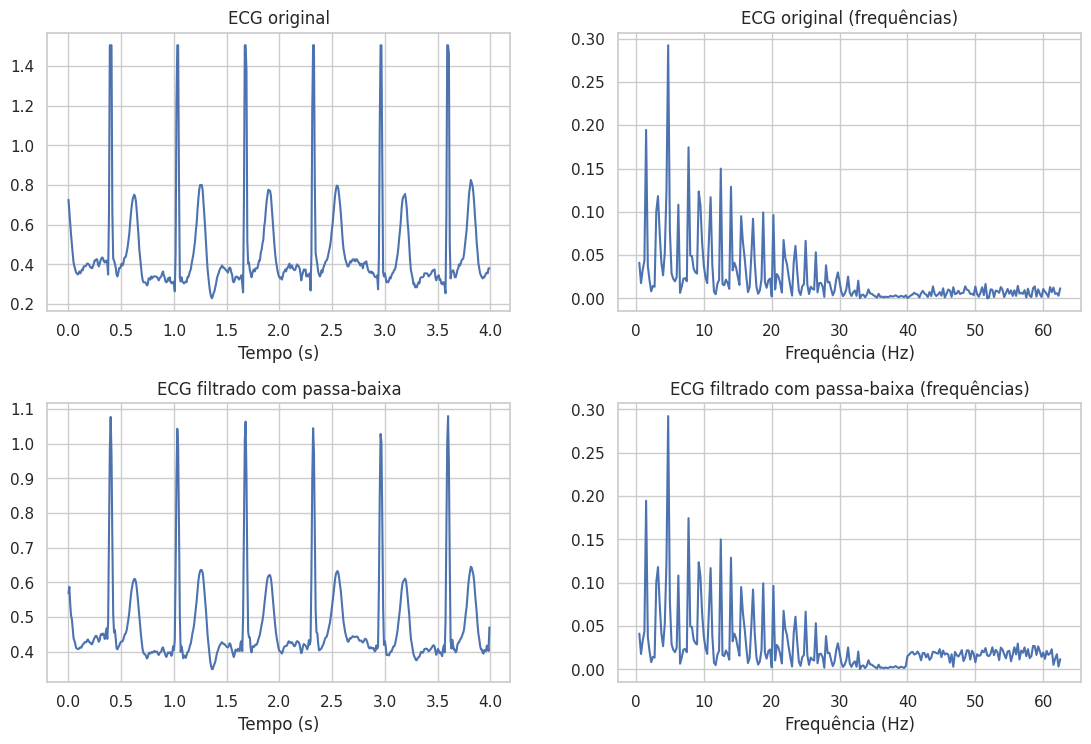

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=[12,8])
fig.tight_layout(pad=3.5)

ax[0][0].plot(t, ecg_data)
ax[0][0].set_title('ECG original')
ax[0][0].set_xlabel('Tempo (s)')

ax[1][0].plot(t, ecg_filt)
ax[1][0].set_title('ECG filtrado com passa-baixa')
ax[1][0].set_xlabel('Tempo (s)')


ax[0][1].plot(f[1:int(N/2)+1], 2*y_mag[1:int(N/2)+1])
ax[0][1].set_title('ECG original (frequências)')
ax[0][1].set_xlabel('Frequência (Hz)')

ax[1][1].plot(f[1:int(N/2)+1], 2*y_mag2[1:int(N/2)+1])
ax[1][1].set_title('ECG filtrado com passa-baixa (frequências)')
ax[1][1].set_xlabel('Frequência (Hz)')

plt.show()